In [2]:
import os
import sys
import warnings
import pandas as pd
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning, module="pandas")

PROJECT_ROOT = r"D:\demand_forecasting_system"
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

from tasks.extract_mssql import fetch_table_data
from tasks.extract_mssql import fetch_all_tables_parallel
from tasks.load_csv import load_all_csv
results = fetch_all_tables_parallel(max_workers=6)  # adjust workers for speed
load_csv_files = load_all_csv()  # if you want to load from CSVs instead

d:\demand_forecasting_system\src\tasks\extract_mssql.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
2025-10-21 21:09:54,257 | INFO | data_pipeline | Fetched 5000 rows from table 'blinkit_order_items' (DB)
2025-10-21 21:09:54,309 | INFO | data_pipeline | Fetched 268 rows from table 'blinkit_products' (DB)
2025-10-21 21:09:54,336 | INFO | data_pipeline | Fetched 2500 rows from table 'blinkit_customers' (DB)
2025-10-21 21:09:54,474 | INFO | data_pipeline | Fetched 5000 rows from table 'blinkit_customer_feedback' (DB)
2025-10-21 21:09:54,538 | INFO | data_pipeline | Fetched 5000 rows from table 'blinkit_delivery_performance' (DB)
2025-10-21 21:09:54,592 | INFO | data_pipeline | Fetched 5000 rows from table 'blinkit_orders' (DB)
2025-10-21 21:09:54,630 | INFO | data_pipeline | Fetched 5400 rows from t

In [4]:
# What tables we got
print(results.keys())
print(load_csv_files.keys())

dict_keys(['blinkit_order_items', 'blinkit_products', 'blinkit_customers', 'blinkit_customer_feedback', 'blinkit_delivery_performance', 'blinkit_orders', 'blinkit_marketing_performance', 'blinkit_weather_data'])
dict_keys(['blinkit_inventory'])


In [5]:
df_products = results['blinkit_products']
df_customers = results['blinkit_customers']
df_orders = results['blinkit_orders']
df_weather = results['blinkit_weather_data']
df_order_items = results['blinkit_order_items']
df_marketing_performance = results['blinkit_marketing_performance']
df_inventory = load_csv_files['blinkit_inventory']

In [6]:
# See first few rows
df_products.describe()
df_customers.describe()
df_orders.describe()
df_weather.describe()
df_order_items.describe()
df_marketing_performance.describe()
df_inventory.describe()
# Check shape
print(f"Products:{df_products.shape}, Customers : {df_customers.shape}, Orders: {df_orders.shape}, Weather: {df_weather.shape}, Order Items: {df_order_items.shape}, Marketing Performance: {df_marketing_performance.shape}, Inventory: {df_inventory.shape}", )

Products:(268, 10), Customers : (2500, 11), Orders: (5000, 10), Weather: (186600, 4), Order Items: (5000, 4), Marketing Performance: (5400, 11), Inventory: (75172, 4)


In [7]:
for df, name in zip(
    [df_orders, df_customers, df_products, df_weather,
        df_order_items, df_marketing_performance, df_inventory],
    ['Orders', 'Customers', 'Products', 'Weather',
        'Order Items', 'Marketing', 'Inventory']
):
    print(f"{name} missing values:\n{df.isnull().sum()}\n")

Orders missing values:
order_id                  0
customer_id               0
order_date                0
promised_delivery_time    0
actual_delivery_time      0
delivery_status           0
order_total               0
payment_method            0
delivery_partner_id       0
store_id                  0
dtype: int64

Customers missing values:
customer_id          0
customer_name        0
email                0
phone                0
address              0
area                 0
pincode              0
registration_date    0
customer_segment     0
total_orders         0
avg_order_value      0
dtype: int64

Products missing values:
product_id           0
product_name         0
category             0
brand                0
price                0
mrp                  0
margin_percentage    0
shelf_life_days      0
min_stock_level      0
max_stock_level      0
dtype: int64

Weather missing values:
area             0
date             0
temperature      0
precipitation    0
dtype: int64

Order I

In [8]:
# Orders: keep essential info for weekly demand aggregation and delivery features
df_orders = df_orders[['order_id', 'customer_id', 'order_date', 'store_id',
                       'order_total', 'delivery_status',
                       'promised_delivery_time', 'actual_delivery_time']]

# Customers: only essential static/customer features
df_customers = df_customers[['customer_id', 'area', 'customer_segment',
                             'total_orders', 'avg_order_value']]

# Products: essential product info
df_products = df_products[['product_id', 'category', 'brand', 'price',
                           'mrp', 'shelf_life_days', 'margin_percentage']]

# Weather: essential weather features
df_weather = df_weather[['area', 'date', 'temperature', 'precipitation']]

# Order Items: needed for demand calculation
df_order_items = df_order_items[['order_id',
                                 'product_id', 'quantity', 'unit_price']]

# Marketing Performance: keep date and metrics; optionally map campaign to product/category later
df_marketing_performance = df_marketing_performance[['date', 'spend', 'impressions',
                                                     'conversions', 'revenue_generated',
                                                     'campaign_name']]

# Inventory: essential for stock/availability features
df_inventory = df_inventory[['product_id',
                             'date', 'stock_received', 'damaged_stock']]

In [9]:
# Step 3: Check datatypes and basic info

print("=== Orders ===")
df_orders.info()
print("\n=== Customers ===")
df_customers.info()
print("\n=== Products ===")
df_products.info()
print("\n=== Weather ===")
df_weather.info()
print("\n=== Order Items ===")
df_order_items.info()
print("\n=== Marketing ===")
df_marketing_performance.info()
print("\n=== Inventory ===")
df_inventory.info()

=== Orders ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   order_id                5000 non-null   int64         
 1   customer_id             5000 non-null   int64         
 2   order_date              5000 non-null   datetime64[ns]
 3   store_id                5000 non-null   int64         
 4   order_total             5000 non-null   float64       
 5   delivery_status         5000 non-null   object        
 6   promised_delivery_time  5000 non-null   datetime64[ns]
 7   actual_delivery_time    5000 non-null   datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(3), object(1)
memory usage: 312.6+ KB

=== Customers ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            -

In [10]:
# Always copy to avoid chained assignment issues
df_orders = df_orders.copy()
df_weather = df_weather.copy()
df_marketing_performance = df_marketing_performance.copy()
df_inventory = df_inventory.copy()

# Convert dates safely
df_orders['order_date'] = pd.to_datetime(
    df_orders['order_date'], errors='coerce')
df_weather['date'] = pd.to_datetime(df_weather['date'], errors='coerce')
df_marketing_performance['date'] = pd.to_datetime(
    df_marketing_performance['date'], errors='coerce')
df_inventory['date'] = pd.to_datetime(
    df_inventory['date'], dayfirst=True, errors='coerce')

In [11]:
print("=== Orders ===")
df_orders.info()
print("\n=== Customers ===")
df_customers.info()
print("\n=== Products ===")
df_products.info()
print("\n=== Weather ===")
df_weather.info()
print("\n=== Order Items ===")
df_order_items.info()
print("\n=== Marketing ===")
df_marketing_performance.info()
print("\n=== Inventory ===")
df_inventory.info()

=== Orders ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   order_id                5000 non-null   int64         
 1   customer_id             5000 non-null   int64         
 2   order_date              5000 non-null   datetime64[ns]
 3   store_id                5000 non-null   int64         
 4   order_total             5000 non-null   float64       
 5   delivery_status         5000 non-null   object        
 6   promised_delivery_time  5000 non-null   datetime64[ns]
 7   actual_delivery_time    5000 non-null   datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(3), object(1)
memory usage: 312.6+ KB

=== Customers ===


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       2500 non-null   int64  
 1   area              2500 non-null   object 
 2   customer_segment  2500 non-null   object 
 3   total_orders      2500 non-null   int64  
 4   avg_order_value   2500 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 97.8+ KB

=== Products ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_id         268 non-null    int64  
 1   category           268 non-null    object 
 2   brand              268 non-null    object 
 3   price              268 non-null    float64
 4   mrp                268 non-null    float64
 5   shelf_life_days    268 non-null    int6

In [12]:
datasets = {
    "Orders": df_orders,
    "Customers": df_customers,
    "Products": df_products,
    "Weather": df_weather,
    "Order_Items": df_order_items,
    "Marketing": df_marketing_performance,
    "Inventory": df_inventory
}
for name, df in datasets.items():
    print(f"{name} Table column names:\n{df.columns}\n")

Orders Table column names:
Index(['order_id', 'customer_id', 'order_date', 'store_id', 'order_total',
       'delivery_status', 'promised_delivery_time', 'actual_delivery_time'],
      dtype='object')

Customers Table column names:
Index(['customer_id', 'area', 'customer_segment', 'total_orders',
       'avg_order_value'],
      dtype='object')

Products Table column names:
Index(['product_id', 'category', 'brand', 'price', 'mrp', 'shelf_life_days',
       'margin_percentage'],
      dtype='object')

Weather Table column names:
Index(['area', 'date', 'temperature', 'precipitation'], dtype='object')

Order_Items Table column names:
Index(['order_id', 'product_id', 'quantity', 'unit_price'], dtype='object')

Marketing Table column names:
Index(['date', 'spend', 'impressions', 'conversions', 'revenue_generated',
       'campaign_name'],
      dtype='object')

Inventory Table column names:
Index(['product_id', 'date', 'stock_received', 'damaged_stock'], dtype='object')



Checking all tables


In [13]:
# List of all tables
tables = {
    "Orders": df_orders,
    "Customers": df_customers,
    "Products": df_products,
    "Weather": df_weather,
    "Order_Items": df_order_items,
    "Marketing_Performance": df_marketing_performance,
    "Inventory": df_inventory
}

# Function to summarize each table


def table_summary(df, table_name):
    print(f"=== {table_name} ===")
    print("Shape:", df.shape)
    print("\nData Types:")
    print(df.dtypes)
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nDuplicate Rows:", df.duplicated().sum())
    print("-"*50)


# Loop through all tables and display summary
for name, df in tables.items():
    table_summary(df, name)

=== Orders ===
Shape: (5000, 8)

Data Types:
order_id                           int64
customer_id                        int64
order_date                datetime64[ns]
store_id                           int64
order_total                      float64
delivery_status                   object
promised_delivery_time    datetime64[ns]
actual_delivery_time      datetime64[ns]
dtype: object

Missing Values:
order_id                  0
customer_id               0
order_date                0
store_id                  0
order_total               0
delivery_status           0
promised_delivery_time    0
actual_delivery_time      0
dtype: int64

Duplicate Rows: 0
--------------------------------------------------
=== Customers ===
Shape: (2500, 5)

Data Types:
customer_id           int64
area                 object
customer_segment     object
total_orders          int64
avg_order_value     float64
dtype: object

Missing Values:
customer_id         0
area                0
customer_segment    0
tota

Fixing Orders Table


In [14]:
# Ensure correct types
df_orders['delivery_status'] = df_orders['delivery_status'].astype('category')

# Ensure order_id, customer_id, store_id are integers
df_orders['order_id'] = df_orders['order_id'].astype(int)
df_orders['customer_id'] = df_orders['customer_id'].astype(int)
df_orders['store_id'] = df_orders['store_id'].astype(int)

# Ensure order_total is non-negative
df_orders = df_orders[df_orders['order_total'] >= 0]

# Optional: create delivery_delay column in minutes
df_orders['delivery_delay_minutes'] = (
    df_orders['actual_delivery_time'] - df_orders['promised_delivery_time']).dt.total_seconds()/60

df_orders.head()

,order_id,customer_id,order_date,store_id,order_total,delivery_status,promised_delivery_time,actual_delivery_time,delivery_delay_minutes
0,60465,15808945,2024-10-23 05:23:29,3943,589.469971,On Time,2024-10-23 05:34:29,2024-10-23 05:39:29,5.0
1,2237858,48281892,2023-04-02 03:45:11,1987,3835.260010,On Time,2023-04-02 04:00:11,2023-04-02 04:03:11,3.0
2,3101265,89617089,2024-05-23 03:21:47,974,3567.729980,On Time,2024-05-23 03:37:47,2024-05-23 03:40:47,3.0
3,5120698,44174426,2023-06-09 12:10:20,3184,3064.360107,Slightly Delayed,2023-06-09 12:25:20,2023-06-09 12:40:20,15.0
4,5512907,51476157,2023-04-30 20:52:21,419,861.530029,Slightly Delayed,2023-04-30 21:11:21,2023-04-30 21:26:21,15.0


Fixing Customers Table


In [15]:
# Convert categorical columns
df_customers['area'] = df_customers['area'].astype('category')
df_customers['customer_segment'] = df_customers['customer_segment'].astype(
    'category')

# Ensure total_orders >= 0
df_customers = df_customers[df_customers['total_orders'] >= 0]

# Ensure avg_order_value >= 0
df_customers = df_customers[df_customers['avg_order_value'] >= 0]

df_customers.head()

C:\Users\Devdip  Mallick\AppData\Local\Temp\ipykernel_12584\869518453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_customers['area'] = df_customers['area'].astype('category')
C:\Users\Devdip  Mallick\AppData\Local\Temp\ipykernel_12584\869518453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_customers['customer_segment'] = df_customers['customer_segment'].astype(


,customer_id,area,customer_segment,total_orders,avg_order_value
0,31813,Sultan Pur Majra,Regular,18,1230.750000
1,31826,Chinsurah,New,18,752.780029
2,61020,Kurnool,New,19,1703.160034
3,75482,Korba,Regular,13,1938.380005
4,119099,Kavali,Inactive,20,637.349976


Fixing Products Table


In [16]:
# Convert categorical columns
df_products['category'] = df_products['category'].astype('category')
df_products['brand'] = df_products['brand'].astype('category')

# Ensure price, mrp, margin >= 0
df_products = df_products[(df_products['price'] >= 0) &
                          (df_products['mrp'] >= 0) &
                          (df_products['margin_percentage'] >= 0)]

# Ensure shelf_life_days > 0
df_products = df_products[df_products['shelf_life_days'] > 0]

df_products.head()

C:\Users\Devdip  Mallick\AppData\Local\Temp\ipykernel_12584\1652509973.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['category'] = df_products['category'].astype('category')
C:\Users\Devdip  Mallick\AppData\Local\Temp\ipykernel_12584\1652509973.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['brand'] = df_products['brand'].astype('category')


,product_id,category,brand,price,mrp,shelf_life_days,margin_percentage
0,4452,Baby Care,Morar-Mistry,169.880005,242.690002,365,30.0
1,6405,Baby Care,Kashyap-Reddy,236.509995,337.869995,365,30.0
2,9436,Personal Care,Naidu PLC,88.430000,136.050003,365,35.0
3,11422,Fruits & Vegetables,Ramaswamy-Tata,127.160004,169.550003,3,25.0
4,14145,Fruits & Vegetables,"Thakur, Shah and Pingle",630.840027,841.119995,3,25.0


Fixing Weather Table


In [17]:
# Convert categorical
df_weather['area'] = df_weather['area'].astype('category')

# Temperature sanity check (e.g., -50 to 60 Celsius)
df_weather = df_weather[(df_weather['temperature'] >= -50)
                        & (df_weather['temperature'] <= 60)]

# Precipitation sanity check (>=0)
df_weather = df_weather[df_weather['precipitation'] >= 0]

df_weather.head()

,area,date,temperature,precipitation
0,Adoni,2023-03-16,7.6,7.5
1,Adoni,2023-03-17,9.6,0.0
2,Adoni,2023-03-18,12.2,0.0
3,Adoni,2023-03-19,15.0,0.0
4,Adoni,2023-03-20,17.0,0.5


Fixing Order Items Table


In [18]:
# Ensure quantity and unit_price >= 0
df_order_items = df_order_items[(df_order_items['quantity'] >= 0) & (
    df_order_items['unit_price'] >= 0)]

df_order_items.head()

,order_id,product_id,quantity,unit_price
0,60465,361361,2,826.210022
1,2237858,585299,1,799.460022
2,3101265,300159,1,44.349998
3,5120698,187399,1,53.490002
4,5512907,659290,3,319.339996


Fixing Marketing Performance Table


In [19]:
# Convert campaign_name to category
df_marketing_performance['campaign_name'] = df_marketing_performance['campaign_name'].astype(
    'category')

# Ensure numeric metrics >= 0
metrics = ['spend', 'impressions', 'conversions', 'revenue_generated']
for col in metrics:
    df_marketing_performance = df_marketing_performance[df_marketing_performance[col] >= 0]

df_marketing_performance.head()

,date,spend,impressions,conversions,revenue_generated,campaign_name
0,2024-08-25,3641.179932,2480,53,5970.430176,Referral Program
1,2023-08-08,2900.459961,6335,43,7711.310059,Flash Sale
2,2023-08-02,2704.169922,9896,53,5202.299805,Email Campaign
3,2024-05-25,1542.650024,4729,95,4316.399902,Festival Offer
4,2023-11-04,4892.220215,7368,43,2261.530029,New User Discount


Fixing Inventory Table


In [20]:
# Ensure stock_received and damaged_stock >= 0
df_inventory = df_inventory[(df_inventory['stock_received'] >= 0) & (
    df_inventory['damaged_stock'] >= 0)]

df_inventory.head()

,product_id,date,stock_received,damaged_stock
0,153019,2023-03-17,4,2
1,848226,2023-03-17,4,2
2,965755,2023-03-17,1,0
3,39154,2023-03-17,4,0
4,34186,2023-03-17,3,2


In [21]:
# Overview of numeric columns
print(df_customers.describe())

# Count of unique values per column
print(df_customers.nunique())

# Check categorical distributions
print(df_customers['area'].value_counts())
print(df_customers['customer_segment'].value_counts())

        customer_id  total_orders  avg_order_value
count  2.500000e+03   2500.000000      2500.000000
mean   4.989961e+07     10.491600      1102.375836
std    2.919266e+07      5.805533       523.043183
min    3.181300e+04      1.000000       200.429993
25%    2.402443e+07      6.000000       631.817490
50%    5.000044e+07     10.000000      1118.650024
75%    7.595459e+07     16.000000      1565.400055
max    9.989390e+07     20.000000      1999.829956
customer_id         2500
area                 316
customer_segment       4
total_orders          20
avg_order_value     2487
dtype: int64
area
Jalna        18
Deoghar      17
Bathinda     17
Orai         17
Ratlam       16
             ..
Cuttack       3
Surat         3
Barasat       3
Phusro        2
Mangalore     1
Name: count, Length: 316, dtype: int64
customer_segment
Regular     639
Premium     633
New         628
Inactive    600
Name: count, dtype: int64


In [22]:
# Missing values
print(df_customers.isnull().sum())

# Duplicate rows
print("Duplicate rows:", df_customers.duplicated().sum())

customer_id         0
area                0
customer_segment    0
total_orders        0
avg_order_value     0
dtype: int64
Duplicate rows: 0


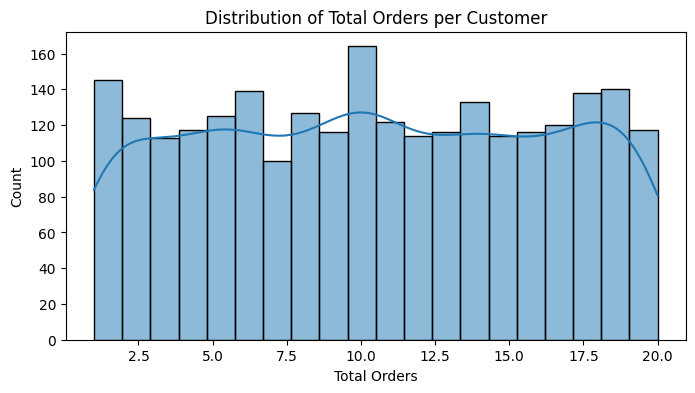

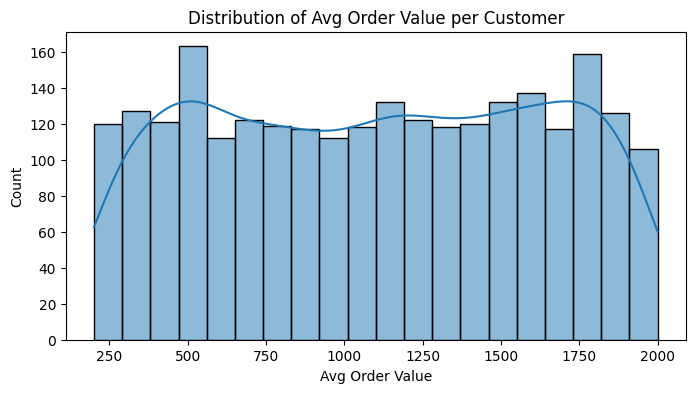

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Total orders
plt.figure(figsize=(8, 4))
sns.histplot(df_customers['total_orders'], bins=20, kde=True)
plt.title('Distribution of Total Orders per Customer')
plt.xlabel('Total Orders')
plt.ylabel('Count')
plt.show()

# Avg order value
plt.figure(figsize=(8, 4))
sns.histplot(df_customers['avg_order_value'], bins=20, kde=True)
plt.title('Distribution of Avg Order Value per Customer')
plt.xlabel('Avg Order Value')
plt.ylabel('Count')
plt.show()

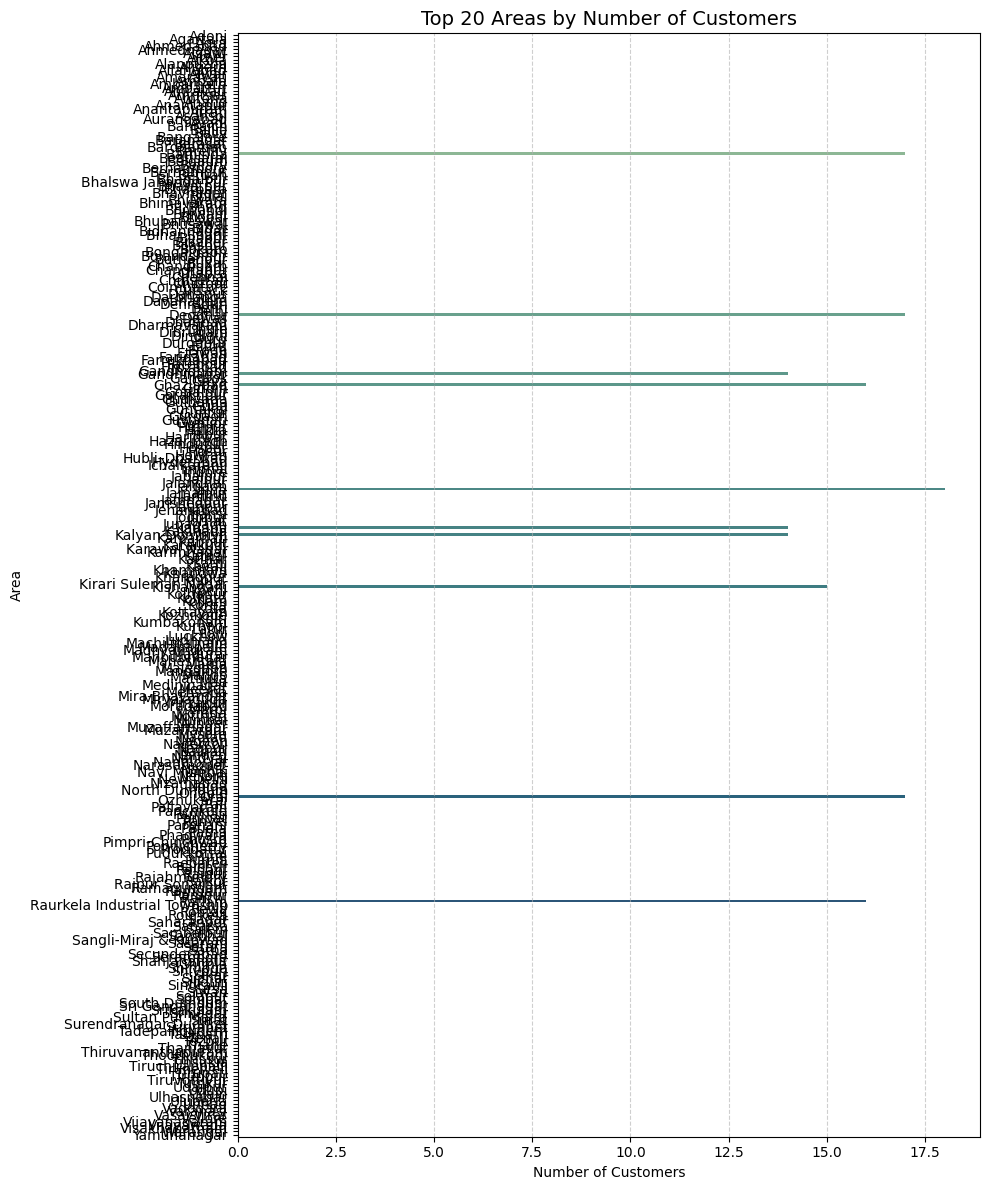

C:\Users\Devdip  Mallick\AppData\Local\Temp\ipykernel_12584\2925757015.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='customer_segment', data=df_customers, palette='pastel')


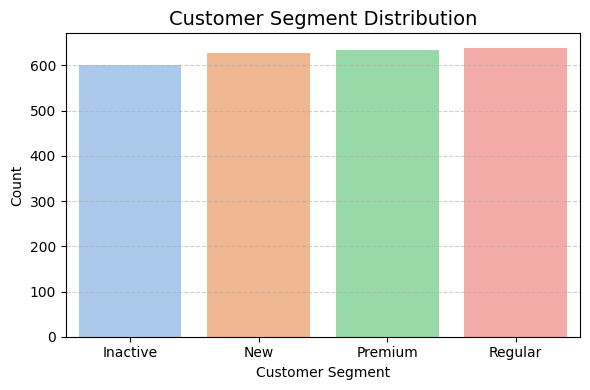

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Area distribution (fixed and future-proof) ---
plt.figure(figsize=(10, 12))
top_20_areas = df_customers['area'].value_counts().head(10).reset_index()
top_20_areas.columns = ['area', 'count']

sns.barplot(
    data=top_20_areas,
    y='area',
    x='count',
    hue='area',           # Add hue to support palette usage
    palette='crest',
    dodge=False,
    legend=False          # Hide redundant legend
)

plt.title('Top 20 Areas by Number of Customers', fontsize=14)
plt.xlabel('Number of Customers')
plt.ylabel('Area')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Customer segment distribution ---
plt.figure(figsize=(6, 4))
sns.countplot(x='customer_segment', data=df_customers, palette='pastel')
plt.title('Customer Segment Distribution', fontsize=14)
plt.xlabel('Customer Segment')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

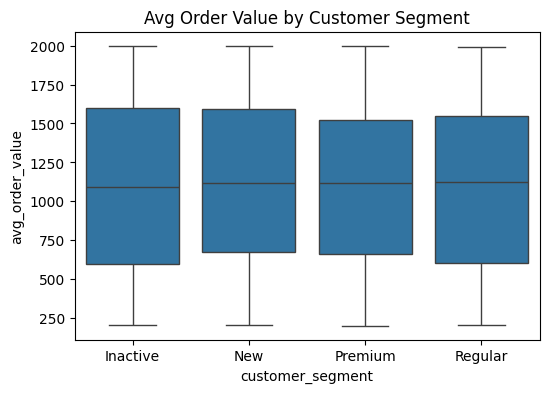

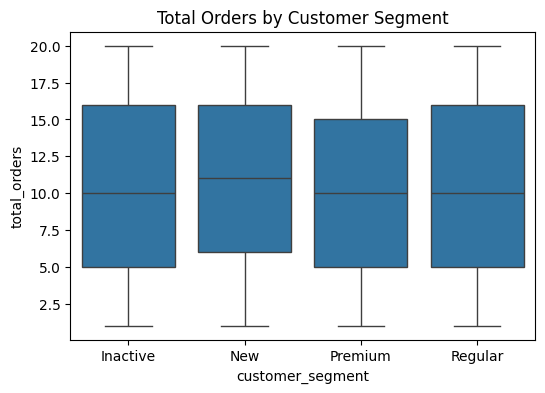

In [25]:
# Avg order value by segment
plt.figure(figsize=(6, 4))
sns.boxplot(x='customer_segment', y='avg_order_value', data=df_customers)
plt.title('Avg Order Value by Customer Segment')
plt.show()

# Total orders by segment
plt.figure(figsize=(6, 4))
sns.boxplot(x='customer_segment', y='total_orders', data=df_customers)
plt.title('Total Orders by Customer Segment')
plt.show()

customer_segment
Inactive    1102.150002
New         1116.635558
Premium     1101.473963
Regular     1089.467044
Name: avg_order_value, dtype: float64
